In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

##### Reading the csv file

In [2]:
# Reading a csv file
city1=pd.read_csv('Nairobi.csv')
city.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Nairobi.csv'

##### Here we are dropping the columns that we don't need for the analysis

In [ ]:
# Dropping unnecessary columns
city=city.drop(["hour","day","year","hod","dow","measurement_count","displayName"], axis=1)
# Checking the first few rows
city.head()

,id,name,month,average,parameter,parameterId,unit,first_datetime,last_datetime
0,2156118,Nairobi,2024-01-01,21.394500,pm10,1,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z
1,2156118,Nairobi,2024-01-01,8.938667,pm25,2,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z
2,2156118,Nairobi,2024-01-01,0.005774,no2,15,ppb,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z
3,2156118,Nairobi,2024-01-01,11.637667,pm1,19,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z
4,2156118,Nairobi,2024-01-01,25.026333,temperature,128,f,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z


##### Checking for duplicate values

In [ ]:
# Check for duplicated rows
duplicates = city[city.duplicated(keep=False)]

# Display the duplicated rows
print(duplicates)

Empty DataFrame
Columns: [id, name, month, average, parameter, parameterId, unit, first_datetime, last_datetime]
Index: []


##### Modifying the months column

In [ ]:
# Creating a dataframe
city = pd.DataFrame(city)

# Convert the 'month' column to datetime
city['month']=pd.to_datetime(city['month'])

# Apply strftime to the 'month' column to format it as "Month Year"
city['formatted_month'] = city['month'].dt.strftime('%B %Y')

# Checking on few rows
city.head()

,id,name,month,average,parameter,parameterId,unit,first_datetime,last_datetime,formatted_month
0,2156118,Nairobi,2024-01-01,21.394500,pm10,1,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
1,2156118,Nairobi,2024-01-01,8.938667,pm25,2,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
2,2156118,Nairobi,2024-01-01,0.005774,no2,15,ppb,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
3,2156118,Nairobi,2024-01-01,11.637667,pm1,19,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
4,2156118,Nairobi,2024-01-01,25.026333,temperature,128,f,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024


In [ ]:
# Removing the previous 'month' column
city=city.drop('month',axis=1)
city.head()
  

,id,name,average,parameter,parameterId,unit,first_datetime,last_datetime,formatted_month
0,2156118,Nairobi,21.394500,pm10,1,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
1,2156118,Nairobi,8.938667,pm25,2,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
2,2156118,Nairobi,0.005774,no2,15,ppb,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
3,2156118,Nairobi,11.637667,pm1,19,µg/m³,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024
4,2156118,Nairobi,25.026333,temperature,128,f,2024-01-28T16:00:00Z,2024-01-28T20:00:00Z,January 2024


In [ ]:
# Splitting the formatted_month column to month and year
city[['months','year']] = city['formatted_month'].str.split(' ',expand=True)
city 

# Removing the formatted_month column
city = city.drop('formatted_month',axis=1)
city.head()

# Export the DataFrame to a CSV file
csv_file_path = 'city_modified.csv'
city.to_csv(csv_file_path, index=False)

#### Origanizing the dataframe in a way that the parameters are the columns

In [ ]:
# Step 1: Assess data completeness
completeness = city.groupby(['name', 'parameter'])['average'].count().unstack()
print("Data completeness (number of measurements):")
print(completeness)

# Calculate the percentage of missing data for each city-parameter combination
missing_percentage = (1 - completeness.divide(completeness.max())) * 100
print("\nPercentage of missing data:")
print(missing_percentage)

# Step 2: Filter out parameters or city with too much missing data
threshold = 50
valid_parameters = missing_percentage.columns[missing_percentage.mean() < threshold]
valid_city = missing_percentage.index[missing_percentage.mean(axis=1) < threshold]

# Filter the original dataset
city_filtered = city[
    (city['name'].isin(valid_city)) & 
    (city['parameter'].isin(valid_parameters))
]

# Step 3: Handle remaining missing values
city_pivoted = city_filtered.pivot_table(
    index=['name', 'months', 'year'],
    columns='parameter',
    values='average'
).reset_index()

city_cleaned = city_pivoted.groupby('name').apply(
    lambda x: x.sort_values(['year', 'months']).ffill()
).reset_index(drop=True)

# Convert 'months' to datetime for proper sorting
city_cleaned['date'] = pd.to_datetime(city_cleaned['year'].astype(str) + ' ' + city_cleaned['months'], format='%Y %B')
city_cleaned = city_cleaned.sort_values(['name', 'date'])

print("\nCleaned data shape:", city_cleaned.shape)
print(city_cleaned.head())

# Get the list of parameters
parameters = city_cleaned.columns.drop(['name', 'months', 'year', 'date'])

# Export the resulting DataFrame to a CSV file
city_cleaned.to_csv('cleaned_city_data.csv', index=False)

Data completeness (number of measurements):
parameter  no2  pm1  pm10  pm25  temperature
name                                        
Nairobi      4    4     4     5            6

Percentage of missing data:
parameter  no2  pm1  pm10  pm25  temperature
name                                        
Nairobi    0.0  0.0   0.0   0.0          0.0

Cleaned data shape: (5, 9)
parameter     name    months  year       no2        pm1       pm10  \
2          Nairobi   January  2024  0.005774  11.637667  21.394500   
1          Nairobi  February  2024  0.003594  14.716939  27.512062   
3          Nairobi     March  2024  0.004861  10.059970  18.094203   
0          Nairobi     April  2024  0.008706  36.023814  44.198553   
4          Nairobi       May  2024  0.004861  10.059970  18.094203   

parameter        pm25  temperature       date  
2            8.938667    25.026333 2024-01-01  
1           12.653482    26.331844 2024-02-01  
3            8.902517    25.403618 2024-03-01  
0           29.4

C:\Users\admin\AppData\Local\Temp\ipykernel_24376\3910207331.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_cleaned = city_pivoted.groupby('name').apply(


##### Unit conversions

In [ ]:
# Load the dataset
file_path = 'cleaned_city_data.csv'  # Update with the correct path to your dataset
df = pd.read_csv(file_path)

# Conversion factors
NO2_conversion_factor = 1.88  # From ppb to µg/m³

# Convert NO2 to µg/m³
df['no2'] = df['no2'] * NO2_conversion_factor

# Assuming temperature values are not being converted to µg/m³
# Drop the temperature column
df = df.drop(['temperature','date','pm1'], axis=1)

# Save the converted dataset
df.to_csv('converted_data.csv', index=False)

print("Conversion completed and saved as 'converted_data.csv'")

Conversion completed and saved as 'converted_data.csv'


##### Calculating AQI

In [ ]:
def calculate_aqi(concentration, breakpoints):
    for low, high, i_low, i_high in breakpoints:
        if low <= concentration <= high:
            return ((i_high - i_low) / (high - low)) * (concentration - low) + i_low
    return None

def calculate_overall_aqi(row, breakpoints):
    aqi_values = []
    for pollutant in ['pm25', 'pm10', 'no2']:
        if pd.notnull(row[pollutant]):
            aqi = calculate_aqi(row[pollutant], breakpoints[pollutant])
            if aqi is not None:
                aqi_values.append(aqi)
    return max(aqi_values) if aqi_values else None

# Load the CSV file
realD = pd.read_csv('converted_data.csv')  # Replace with your actual file name

# Define the breakpoints
breakpoints = {
    'pm25': [(0.0, 42.0, 0, 50), (42.1, 84.0, 51, 100), (84.1, 126.0, 101, 150), 
             (126.1, 168.0, 151, 200), (168.1, 210.0, 201, 300)],
    'pm10': [(0.0, 54.0, 0, 50), (55.1, 154.0, 51, 100), (155.0, 254.0, 101, 150), 
             (255.0, 354.0, 151, 200), (355.0, 424.0, 201, 300)],
    'no2': [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), 
            (361, 649, 151, 200), (650, 1249, 201, 300), (1250, 1649, 301, 400), 
            (1650, 2049, 401, 500)]
}

# Calculate AQI for each pollutant and overall AQI
for pollutant in ['pm25', 'pm10', 'no2']:
    realD[f'{pollutant}_aqi'] = realD[pollutant].apply(lambda x: calculate_aqi(x, breakpoints[pollutant]))

realD['overall_aqi'] = realD.apply(lambda row: calculate_overall_aqi(row, breakpoints), axis=1)

# Save the results
realD.to_csv('nairobi_aqi_results.csv', index=False)

print(realD.head())  # Display the first few rows of the results

      name    months  year       no2       pm10        pm25    pm25_aqi  \
0  Nairobi   January  2024  0.010855  21.394500    8.938667   10.641270   
1  Nairobi  February  2024  0.006757  27.512062   12.653482   15.063669   
2  Nairobi     March  2024  0.009139  18.094203    8.902517   10.598234   
3  Nairobi     April  2024  0.016367  44.198553   29.404269   35.005082   
4  Nairobi       May  2024  0.009139  18.094203  151.413972  180.603452   

    pm10_aqi   no2_aqi  overall_aqi  
0  19.809722  0.010240    19.809722  
1  25.474131  0.006375    25.474131  
2  16.753891  0.008622    16.753891  
3  40.924586  0.015440    40.924586  
4  16.753891  0.008622   180.603452  


##### Rounding the values of the AQI

In [ ]:
# Drop specified columns
rnew= pd.read_csv('nairobi_aqi_results.csv')
rnew.drop(columns=['pm10', 'pm25','no2'], inplace=True, errors='ignore')

# Round the average column
rnew[['pm25_aqi','pm10_aqi','no2_aqi','overall_aqi']] = rnew[['pm25_aqi','pm10_aqi','no2_aqi','overall_aqi']].round()

# Export the resulting DataFrame to a CSV file
rnew.to_csv('nairobi_aqii_results.csv', index=False)
rnew.head()

,name,months,year,pm25_aqi,pm10_aqi,no2_aqi,overall_aqi
0,Nairobi,January,2024,11.0,20.0,0.0,20.0
1,Nairobi,February,2024,15.0,25.0,0.0,25.0
2,Nairobi,March,2024,11.0,17.0,0.0,17.0
3,Nairobi,April,2024,35.0,41.0,0.0,41.0
4,Nairobi,May,2024,181.0,17.0,0.0,181.0


##### Computing Summary Statistics on the AQIs

In [ ]:
# Load the cleaned data
fnew = pd.read_csv('nairobi_aqii_results.csv')

# Get the list of parameters excluding 'name', 'months', 'year'
parameters = fnew.columns.drop(['name', 'months', 'year'])

# Summary Statistics
summary_stats = fnew.groupby('name')[parameters].agg(['mean', 'median', 'std', 'min', 'max'])
print("Summary Statistics:")
summary_stats


Summary Statistics:


pm25_aqi                                pm10_aqi                    \
            mean median        std   min    max     mean median        std   
name                                                                         
Nairobi     50.6   15.0  73.571734  11.0  181.0     24.0   20.0  10.049876   

                    no2_aqi                       overall_aqi         \
          min   max    mean median  std  min  max        mean median   
name                                                                   
Nairobi  17.0  41.0     0.0    0.0  0.0  0.0  0.0        56.8   25.0   

                                 
               std   min    max  
name                             
Nairobi  70.044272  17.0  181.0

#### Analyzing monthly trends and exporting it in excel

In [ ]:
# Seasonal patterns
seasonal_avg = fnew.groupby(['name', 'months'])[parameters].mean().reset_index()
print("\nSeasonal patterns:")
print(seasonal_avg)


Seasonal patterns:
      name    months  pm25_aqi  pm10_aqi  no2_aqi  overall_aqi
0  Nairobi     April      35.0      41.0      0.0         41.0
1  Nairobi  February      15.0      25.0      0.0         25.0
2  Nairobi   January      11.0      20.0      0.0         20.0
3  Nairobi     March      11.0      17.0      0.0         17.0
4  Nairobi       May     181.0      17.0      0.0        181.0


##### Visualizaions

#### Trends of each parameter aqi and the over all aqi through out months

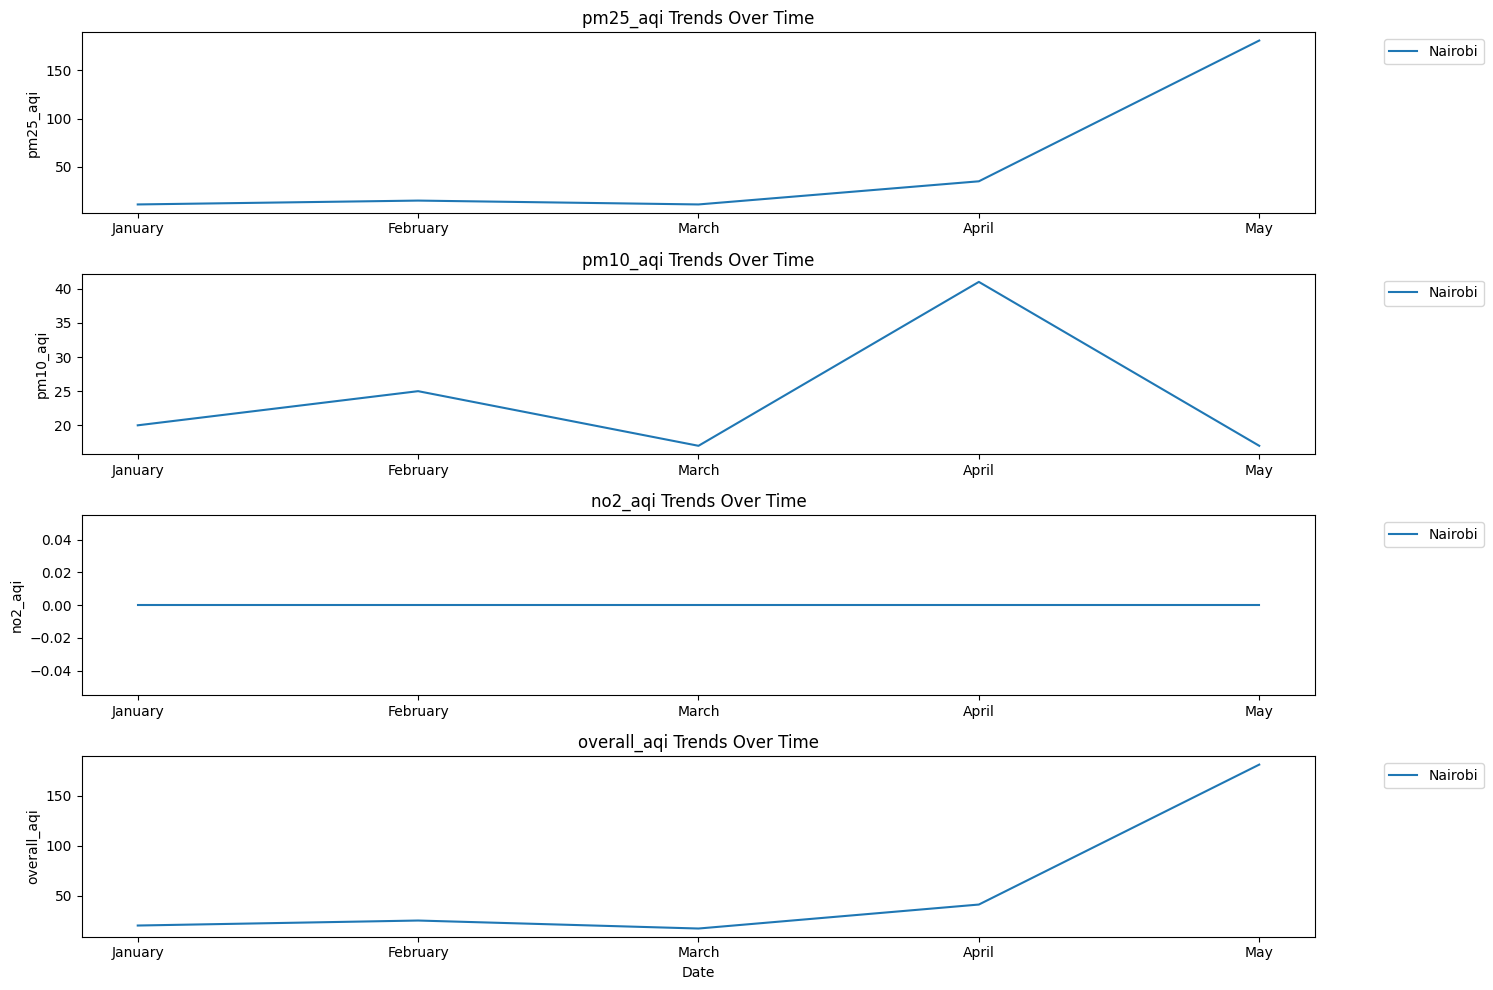

In [ ]:
# Time series plots
plt.figure(figsize=(15, 10))
for i, param in enumerate(parameters, 1):
    plt.subplot(len(parameters), 1, i)
    for city in fnew['name'].unique():
        city_data = fnew[fnew['name'] == city]
        plt.plot(city_data['months'], city_data[param], label=city)
    plt.ylabel(param)
    if i == len(parameters):
        plt.xlabel('Date')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'{param} Trends Over Time')
plt.tight_layout()
plt.show()


##### Parameter trends with in Nairobi
- This helps understand which parameter has significant effect in a Nairobi city

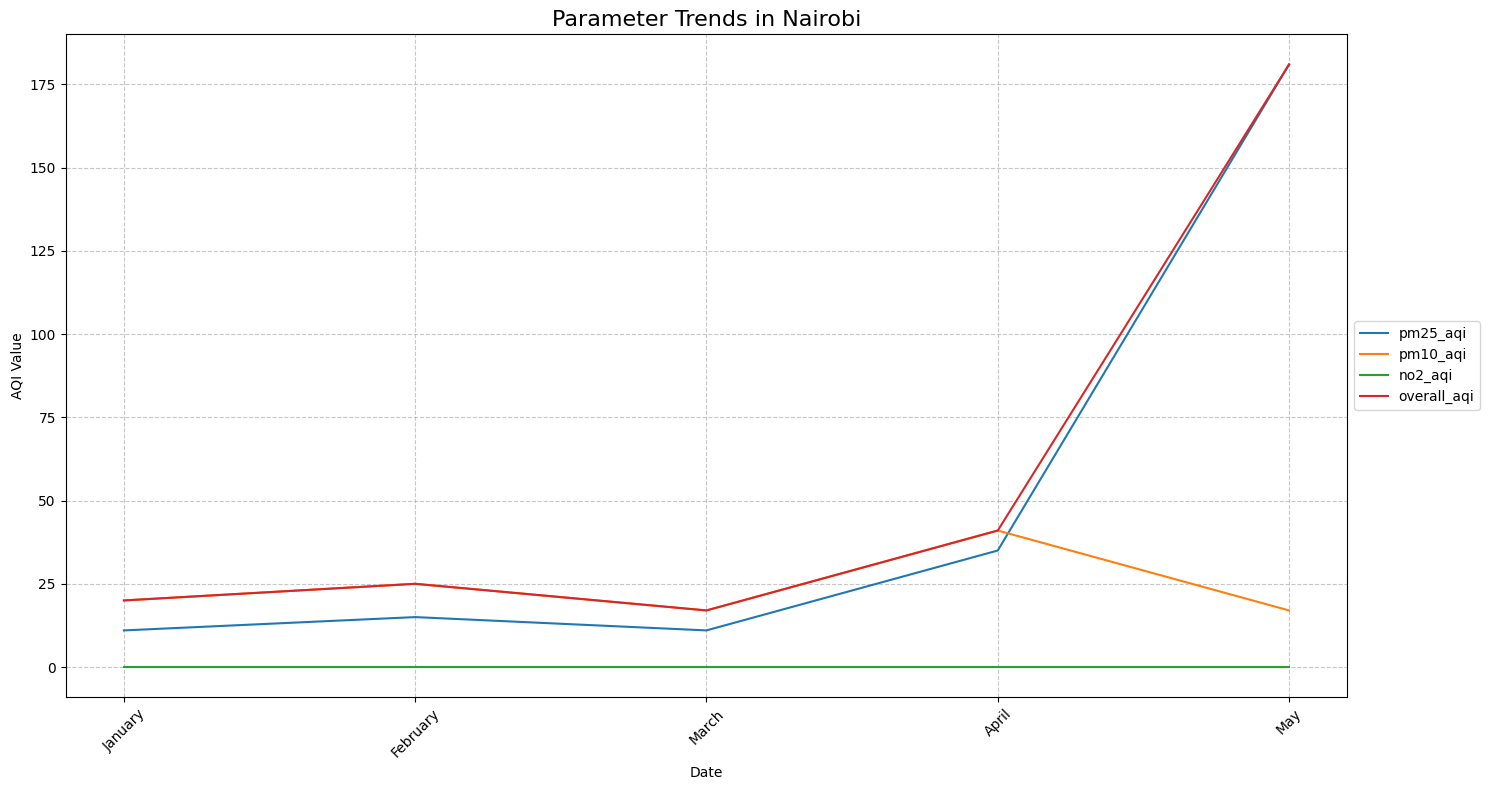

In [ ]:
# Comparison of parameter trends within each city using a single plot
for city in fnew['name'].unique():
    city_data = fnew[fnew['name'] == city]
    
    plt.figure(figsize=(15, 8))
    for param in parameters:
        plt.plot(city_data['months'], city_data[param], label=param)
    
    plt.title(f'Parameter Trends in {city}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('AQI Value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()